# Oslo Bike Share System Analysis

Oslo's bike-sharing system, *Bysykkel*, is a popular way to get around the city. Historical ride data is freely available — a paradise for any data scientist. In this project, I explore how topography influences bike movement patterns, identify critical stations in the network, and examine rebalancing needs and temporal usage dynamics.

## Project Goal

To discover actionable insights about Oslo’s bike-sharing system by analyzing patterns driven by topography, network structure, and temporal dynamics — with the aim of supporting operational improvements and user experience.

## Key Questions

1. **How does topography affect the flow of bikes?**
2. **Which stations are most important to the network?**
3. **What temporal patterns drive rebalancing needs?**
4. **How can the system be optimized for better efficiency and reliability?**

**Data Source:** [Oslo Bysykkel Historical Data](https://oslobysykkel.no/apne-data/historisk) (using all data from 2024)

## Project Overview

1. **Data Exploration**
2. **Cleaning in SQL**
3. **Topographical Flow Analysis**
4. **Network Structure Analysis**
5. **Temporal Flow Analysis**
6. **Rebalancing Insights & Optimization**

---

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import duckdb
import glob
import requests
import os
from datetime import datetime as dt
import seaborn as sns
import folium

## 1. Data Exploration
In this phase, we'll explore the dataset in order to find data quality issues. The findings will be used to determine what cleaning steps are needed.
 
### 1.1 Loading the data
This step reads all monthly CSV files from the `../data/` folder and loads them into a DuckDB database file (`db/bysykkel_2024.duckdb`). If the database doesn't exist, it will be created. 

In [2]:
# Load all CSVs into DuckDB table 'trips_raw'
con = duckdb.connect("../db/bysykkel_2024.duckdb")

csv_files = glob.glob("../data/??.csv")
for i, file in enumerate(csv_files):
    if i == 0:
        con.execute(f"CREATE OR REPLACE TABLE trips_raw AS SELECT * FROM read_csv_auto('{file}')")
    else:
        con.execute(f"INSERT INTO trips_raw SELECT * FROM read_csv_auto('{file}')")

con.execute("CHECKPOINT")
print("Loaded trips_raw data into DuckDB")

Loaded trips_raw data into DuckDB


### 1.2 Exploring Dataset and Columns
In this step we'll explore all the columns to get familiar with the dataset and detect data quality issues. 

In [3]:
trips = con.execute('SELECT * FROM trips_raw').df()
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143379 entries, 0 to 1143378
Data columns (total 13 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   started_at                 1143379 non-null  datetime64[ns]
 1   ended_at                   1143379 non-null  datetime64[ns]
 2   duration                   1143379 non-null  int64         
 3   start_station_id           1143379 non-null  int64         
 4   start_station_name         1143379 non-null  object        
 5   start_station_description  1143374 non-null  object        
 6   start_station_latitude     1143379 non-null  float64       
 7   start_station_longitude    1143379 non-null  float64       
 8   end_station_id             1143379 non-null  int64         
 9   end_station_name           1143379 non-null  object        
 10  end_station_description    1143374 non-null  object        
 11  end_station_latitude       1143379 no

The dataset contains 13 columns, where each column represents one ride. Only the `start_station_description`and the `end_station_description` contain null values. These columns contain no value to the project and will be discarded.  
  
❗ Drop start_station_description and end_station_description columns

#### 1.2.1 started_at & ended_at
These columns state the times at which a ride was started and ended. 

In [4]:
# Sanity check: Check if ended_at is always after started_at
(trips['ended_at'] >= trips['started_at']).all()
print(f"Are all return times after the trip was started? {(trips['ended_at'] >= trips['started_at']).all()}")

Are all return times after the trip was started? True


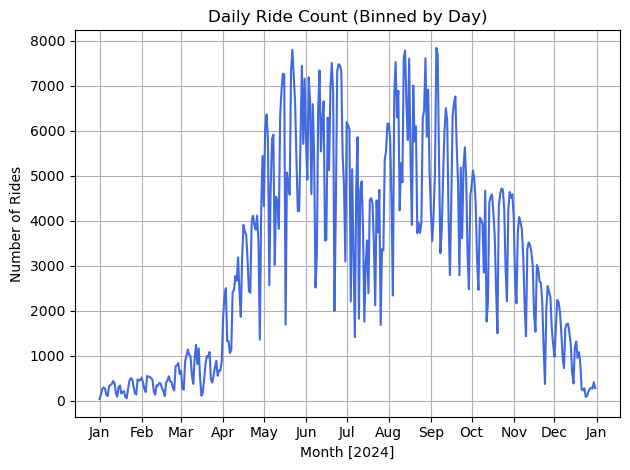

In [5]:
# Plot usage frequency

import matplotlib.dates as mdates

# Group by day
daily = trips.groupby(trips['started_at'].dt.date).size()

# Convert index to datetime (from date)
daily.index = pd.to_datetime(daily.index)

# Plot
plt.figure()
plt.plot(daily.index, daily.values, color='royalblue')

# Format x-axis with months
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.title("Daily Ride Count (Binned by Day)")
plt.xlabel("Month [2024]")
plt.ylabel("Number of Rides")
plt.grid(True)
plt.tight_layout()
plt.show()

✅ No problems detected in this column.

#### 1.2.2 Duration
The `duration` column states the duration of the ride in seconds. 

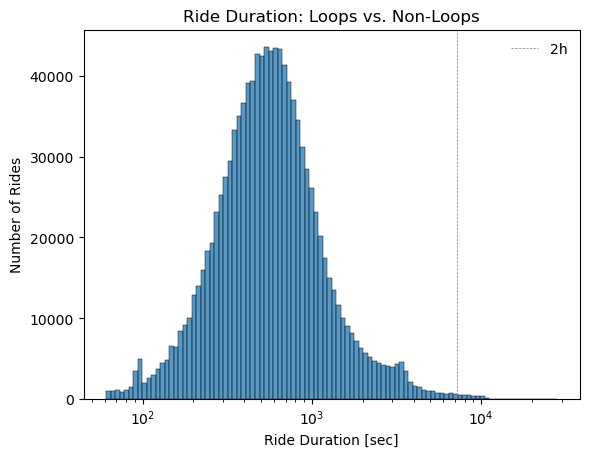

In [6]:
# Plot duration distribution, log scale helps
plt.figure()
sns.histplot(data=trips, x='duration', bins=100, log_scale=True)
plt.title("Ride Duration: Loops vs. Non-Loops")
plt.xlabel("Ride Duration [sec]")
plt.axvline(7200, c='grey', linewidth=0.5, linestyle='--', label="2h")
plt.legend(frameon=False)
plt.ylabel("Number of Rides");

In [7]:
print(f"""
There are {(trips[trips['duration']>7200]).size} rides that exceed 2 hours. It is likely that these are not actual rides but bikes that were unsuccessfully returned. We will remove these from the dataset.  
""")


There are 44343 rides that exceed 2 hours. It is likely that these are not actual rides but bikes that were unsuccessfully returned. We will remove these from the dataset.  



✅ No missing values.  
❗ Remove rides longer than 2 hours. 

#### 1.2.3 start_station_id & end_station_id
These columns state a unique id for each station. 

In [8]:
print(f"Number of start stations: {len(set(trips['start_station_id']))}")
print(f"Number of start stations: {len(set(trips['end_station_id']))}")

Number of start stations: 274
Number of start stations: 274


In [9]:
start_ids = set(trips['start_station_id'].unique())
end_ids = set(trips['end_station_id'].unique())

only_start = start_ids - end_ids
only_end = end_ids - start_ids

print(f"Start-only stations: {len(only_start)}")
print(f"End-only stations: {len(only_end)}")

Start-only stations: 0
End-only stations: 0


Check how many trips are **loops**, so trips where the start and end stations are identical. These might distort the picture. 

In [10]:
print(f"There are {len(trips[trips['start_station_id']==trips['end_station_id']])} trips with identical start and end point. These will be discarded.")

There are 30188 trips with identical start and end point. These will be discarded.


✅ No missing values.  
❗ Remove loops

#### 1.2.3 start_station_name & end_station_name

In [11]:
print(f"Number of start stations: {len(set(trips['start_station_name']))}")
print(f"Number of start stations: {len(set(trips['end_station_name']))}")

Number of start stations: 276
Number of start stations: 276


There are two more unique station names than station id's. 

In [12]:
start_names = set(trips['start_station_name'].unique())
end_names = set(trips['end_station_name'].unique())

only_start_names = start_names - end_names
only_end_names = end_names - start_names

print(f"Start-only station names: {len(only_start_names)}")
print(f"End-only station names: {len(only_end_names)}")

Start-only station names: 0
End-only station names: 0


In [13]:
start_name_map = (
    trips[['start_station_id', 'start_station_name']]
    .drop_duplicates()
    .groupby('start_station_id')['start_station_name']
    .nunique()
)

# IDs with >1 unique name
inconsistent_ids = start_name_map[start_name_map > 1]
print(f"Start station IDs with multiple names: {len(inconsistent_ids)}")
print(inconsistent_ids.head())

Start station IDs with multiple names: 2
start_station_id
608     2
1101    2
Name: start_station_name, dtype: int64


In [14]:
end_name_map = (
    trips[['end_station_id', 'end_station_name']]
    .drop_duplicates()
    .groupby('end_station_id')['end_station_name']
    .nunique()
)

# IDs with >1 unique name
inconsistent_ids = end_name_map[end_name_map > 1]
print(f"End station IDs with multiple names: {len(inconsistent_ids)}")
print(inconsistent_ids.head())

End station IDs with multiple names: 2
end_station_id
608     2
1101    2
Name: end_station_name, dtype: int64


In [15]:
df = trips[trips['start_station_id']==608]
df['start_station_name'].unique()

array(['Colletts gate', 'Diriks gate'], dtype=object)

In [16]:
df = trips[trips['start_station_id']==1101]
df['start_station_name'].unique()

array(['Stortingstunellen', 'Stortingstunnelen'], dtype=object)

❗ station_id 608 and 1101 don't have unique names. There is a small subset (~1%) of alternative names. When creating a station table it is important to use the station_id as the unique identifier.

#### 1.2.4 start_station_latitude, end_station_latitude, start_station_longitude, end_station_longitude

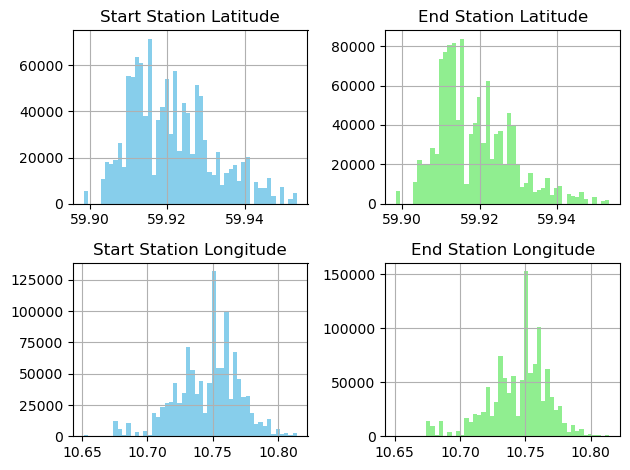

In [17]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2)

trips['start_station_latitude'].hist(ax=axs[0, 0], bins=50, color='skyblue')
axs[0, 0].set_title('Start Station Latitude')

trips['end_station_latitude'].hist(ax=axs[0, 1], bins=50, color='lightgreen')
axs[0, 1].set_title('End Station Latitude')

trips['start_station_longitude'].hist(ax=axs[1, 0], bins=50, color='skyblue')
axs[1, 0].set_title('Start Station Longitude')

trips['end_station_longitude'].hist(ax=axs[1, 1], bins=50, color='lightgreen')
axs[1, 1].set_title('End Station Longitude')

plt.tight_layout()
plt.show()

### Column Audit Summary

| Column                      | Notes                                                                 |
|-----------------------------|-----------------------------------------------------------------------|
| `started_at`, `ended_at`    | ✅ Valid timestamps, no missing values. |
| `duration`                  | ⚠️ No missing values, but contains outliers > 2 hours → to be removed in SQL. |
| `start_station_id`          | ✅ Valid IDs. However, 30,188 trips are loops (start = end) → to be removed. |
| `end_station_id`            | ✅ Valid IDs. Same note as above.                                    |
| `start_station_name`        | ⚠️ Mostly consistent. Two IDs (608 and 1101) map to multiple names. Will use the most common. |
| `end_station_name`          | ⚠️ Same as above. No major action needed if we trust IDs.            |
| `start_station_description` | ❌ Incomplete. Will be dropped in cleaning step.                 |
| `end_station_description`   | ❌ Same as above.                                                    |
| `start_station_latitude`    | ✅ All values present. Range appears valid.                          |
| `end_station_latitude`      | ✅ Same as above.                                                    |
| `start_station_longitude`   | ✅ All values present. Range appears valid.                          |
| `end_station_longitude`     | ✅ Same as above.                                                    |


### Cleaning Actions to Apply in SQL

- Remove trips longer than 2 hours  
- Remove loops (start and end station ID are the same)  
- Drop `start_station_description` and `end_station_description`  

---
## 2. Cleaning in SQL
In this step we'll clean the dataset and address the problems identified in our exploration phase.

The goal is to create two tables:
1. `trips_clean`: A filtered dataset without outliers and unnecessary columns, ready for analysis in pandas
2. `stations`: A normalized table listing all stations in the system, containing consistent names, station IDs, and geographic coordinates

### 2.1 trips_clean

In [18]:
# Remove rides longer than 2 hours (= 7200 sec)
# Remove loops
# Drop station descriptions

con.execute("""
CREATE OR REPLACE TABLE trips_clean AS
SELECT 
    * EXCLUDE (start_station_description, end_station_description)
FROM trips_raw
WHERE
    duration < 7200 AND
    start_station_id != end_station_id
""")
con.execute("CHECKPOINT")
print("Cleaned trips saved to DuckDB as 'trips_clean'");

Cleaned trips saved to DuckDB as 'trips_clean'


### 2.2 Extract Unique Stations  
Build a `stations` table by combining all distinct start and end stations from the `trips_clean` table. This gives the full list of physical bike stations to enrich with elevation later.

In [19]:
con.execute("""
CREATE OR REPLACE TABLE stations AS
SELECT DISTINCT
    station_id,
    station_name,
    ROUND(lat, 5) AS lat,
    ROUND(lon, 5) AS lon
FROM (
    SELECT
        start_station_id AS station_id,
        start_station_name AS station_name,
        start_station_latitude AS lat,
        start_station_longitude AS lon
    FROM trips_clean

    UNION ALL

    SELECT
        end_station_id AS station_id,
        end_station_name AS station_name,
        end_station_latitude AS lat,
        end_station_longitude AS lon
    FROM trips_clean
)
ORDER BY station_id
""")

con.execute("CHECKPOINT")
print("Extracted and saved 'stations' table")

Extracted and saved 'stations' table


---
## 3. Topography-Flow Analysis
In this phase of the project we'll investigate whether Oslo's topography influences bike usage behaviour. Oslo has a natural gradient from sea level upwards, which suggests that cyclists might prefer the downhill over the uphill routes.  

**Questions we'll answer:**
1. Do cyclists prefer downhill routes? If yes, by what margin?
2. How does elevation affect station imbalance? Where does the net flux go?
3. What stations are consistent exporters and importers of bikes? 
4. How do trip characteristics such as distance and duration differ between uphill and downhill rides?